## 1. Importações e Configuração Inicial

Primeiro, vamos importar todas as bibliotecas necessárias para o processamento de dados Sentinel-1:


In [21]:
import os
from dotenv import load_dotenv
from sentinelhub import SHConfig, SentinelHubRequest, DataCollection, BBox, CRS, MimeType
import matplotlib.pyplot as plt
import rasterio
import requests
import glob


print("✓ Bibliotecas importadas com sucesso!")

✓ Bibliotecas importadas com sucesso!


## 2. Carregamento das Credenciais

Agora vamos carregar as credenciais do arquivo `.env`. Certifique-se de ter um arquivo `.env` na mesma pasta com suas credenciais do Copernicus CDSE:

In [4]:
load_dotenv()

client_id = os.getenv("CLIENT_ID")
client_secret = os.getenv("CLIENT_SECRET_ID")

if not client_id or not client_secret:
    raise ValueError("❌ Credenciais CLIENT_ID ou CLIENT_SECRET_ID não encontradas no .env")

print("✓ Credenciais carregadas do arquivo .env")
print(f"Client ID: {client_id[:10]}...")  # Mostra apenas os primeiros caracteres

✓ Credenciais carregadas do arquivo .env
Client ID: sh-02df45a...


## 3. Configuração do SentinelHub

Vamos configurar a conexão com o serviço SentinelHub do Copernicus CDSE:

In [7]:
def setup_sentinelhub_config():
    """Configura e autentica no Copernicus Data Space Ecosystem."""
    config = SHConfig()
    
    # Configurar credenciais
    config.sh_client_id = client_id.strip()
    config.sh_client_secret = client_secret.strip()
    
    # URLs específicas do CDSE
    config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
    config.sh_base_url = "https://sh.dataspace.copernicus.eu"
    
    return config

config = setup_sentinelhub_config()
print("✓ Configuração do SentinelHub criada")

✓ Configuração do SentinelHub criada


## 4. Teste de Autenticação

Antes de prosseguir, vamos testar se a autenticação está funcionando corretamente:

In [8]:
def test_authentication(config):
    """Testa a conexão com o Copernicus CDSE."""
    try:
        response = requests.post(
            config.sh_token_url,
            data={
                'grant_type': 'client_credentials',
                'client_id': config.sh_client_id,
                'client_secret': config.sh_client_secret
            },
            headers={'Content-Type': 'application/x-www-form-urlencoded'}
        )
        response.raise_for_status()
        print("✓ Autenticação no Copernicus CDSE bem-sucedida!")
        return True
    
    except Exception as e:
        print(f"❌ Falha na autenticação: {e}")
        return False

# Testar autenticação
auth_success = test_authentication(config)

✓ Autenticação no Copernicus CDSE bem-sucedida!


## 5. Definição da Área de Interesse

Vamos definir a área geográfica de onde queremos baixar os dados. O exemplo usa uma região da Amazônia:


In [9]:
# Definir bounding box (área de interesse)
# Coordenadas: [longitude_min, latitude_min, longitude_max, latitude_max]
bbox = BBox(bbox=[-60.5, -3.5, -59.5, -2.5], crs=CRS.WGS84)

print("✓ Área de interesse definida:")
print(f"  Longitude: {bbox.min_x}° a {bbox.max_x}°")
print(f"  Latitude: {bbox.min_y}° a {bbox.max_y}°")
print(f"  Região: Amazônia (aproximadamente)")

✓ Área de interesse definida:
  Longitude: -60.5° a -59.5°
  Latitude: -3.5° a -2.5°
  Região: Amazônia (aproximadamente)


## 6. Definição do Evalscript

O evalscript define como os dados serão processados. Aqui vamos extrair apenas a banda VV (polarização vertical-vertical) do Sentinel-1:


In [10]:
# Script de processamento para extrair banda VV do Sentinel-1
evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["VV"],
    output: { bands: 1 }
  };
}

function evaluatePixel(sample) {
  return [sample.VV];
}
"""

print("✓ Evalscript definido para banda VV (polarização vertical)")

✓ Evalscript definido para banda VV (polarização vertical)


## 7. Criação da Requisição SentinelHub

Agora vamos criar a requisição que será enviada para o SentinelHub para baixar os dados:

In [17]:
def create_sentinel_request(config, bbox, evalscript, date_start="2025-07-09", date_end="2025-07-09"):
    """Cria uma requisição para baixar dados Sentinel-1."""
    
    request = SentinelHubRequest(
        data_folder='.',
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL1_IW.define_from(
                    name="S1IW", 
                    service_url="https://sh.dataspace.copernicus.eu"
                ),
                time_interval=(date_start, date_end),
            )
        ],
        responses=[
            SentinelHubRequest.output_response("default", MimeType.TIFF)
        ],
        bbox=bbox,
        size=(512, 512),  # Resolução da imagem
        config=config
    )
    
    return request

# Criar requisição
request = create_sentinel_request(config, bbox, evalscript, date_start="2025-07-01", date_end="2025-07-15")
print("✓ Requisição SentinelHub criada")
print(f"  Data: 2025-07-01 a 2025-07-15")
print(f"  Resolução: 512x512 pixels")
print(f"  Formato: TIFF")


✓ Requisição SentinelHub criada
  Data: 2025-07-01 a 2025-07-15
  Resolução: 512x512 pixels
  Formato: TIFF


## 8. Download da Imagem

Vamos executar o download dos dados Sentinel-1:

In [22]:
if auth_success:
    print("📡 Iniciando download da imagem Sentinel-1...")
    try:
        request.save_data()
        # Procura o arquivo TIFF salvo na pasta atual ou subpastas
        tiff_files = sorted(glob.glob("./**/response.tiff", recursive=True), key=os.path.getmtime, reverse=True)
        if tiff_files:
            print("✓ Download concluído!")
            print(f"  Arquivo salvo em: {tiff_files[0]}")
            data_path = tiff_files[0]
        else:
            print("❌ Download realizado, mas nenhum arquivo TIFF encontrado.")
            data_path = None
    except Exception as e:
        print(f"❌ Erro no download: {e}")
        data_path = None
else:
    print("❌ Pulando download devido à falha na autenticação")
    data_path = None

📡 Iniciando download da imagem Sentinel-1...
✓ Download concluído!
  Arquivo salvo em: ./2ffdaabed60822fdb070862188fbe274/response.tiff


## 9. Visualização da Imagem

Agora vamos visualizar a imagem baixada usando matplotlib:

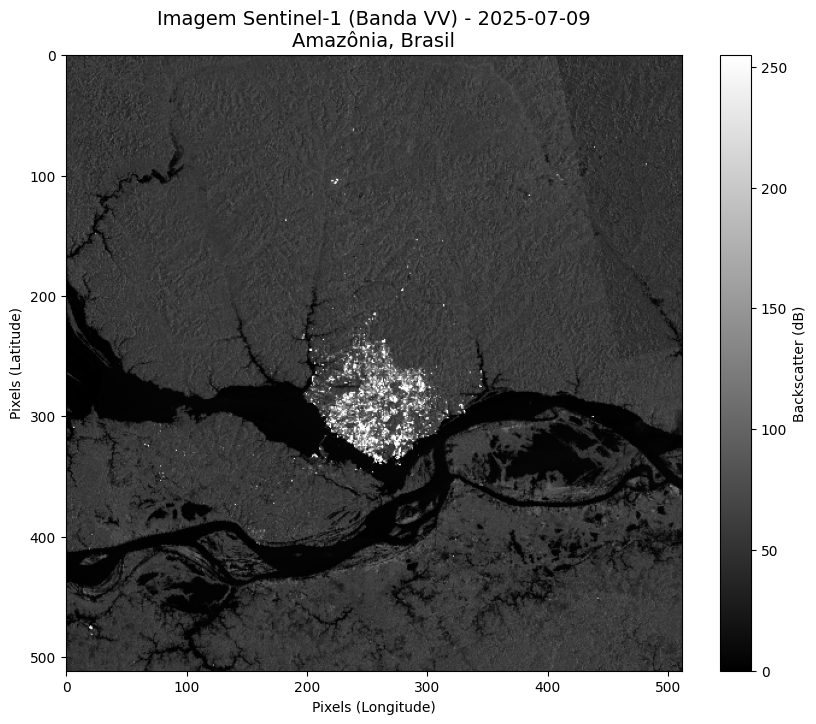

✓ Visualização criada e salva como 's1_preview.png'
  Dimensões da imagem: (512, 512)
  Valores mín/máx: 0.00 / 255.00


In [23]:
def visualize_sentinel_image(data_path):
    """Visualiza a imagem Sentinel-1 baixada."""
    if not data_path or not os.path.exists(data_path):
        print("❌ Arquivo de imagem não encontrado")
        return
    
    try:
        # Abrir e ler a imagem
        with rasterio.open(data_path) as src:
            image = src.read(1)  # Ler primeira banda
            
            # Criar visualização
            plt.figure(figsize=(10, 8))
            plt.imshow(image, cmap="gray")
            plt.title("Imagem Sentinel-1 (Banda VV) - 2025-07-09\nAmazônia, Brasil", fontsize=14)
            plt.colorbar(label="Backscatter (dB)")
            plt.xlabel("Pixels (Longitude)")
            plt.ylabel("Pixels (Latitude)")
            
            # Salvar visualização
            plt.savefig("s1_preview.png", dpi=300, bbox_inches='tight')
            plt.show()
            
            print("✓ Visualização criada e salva como 's1_preview.png'")
            print(f"  Dimensões da imagem: {image.shape}")
            print(f"  Valores mín/máx: {image.min():.2f} / {image.max():.2f}")
            
    except Exception as e:
        print(f"❌ Erro na visualização: {e}")

# Visualizar se o download foi bem-sucedido
if 'data_path' in locals() and data_path:
    visualize_sentinel_image(data_path)

## 10. Resumo e Informações Finais

Por fim, vamos exibir um resumo da execução e informações sobre os arquivos gerados:

In [ ]:
print("\n" + "="*50)
print("📋 RESUMO DA EXECUÇÃO")
print("="*50)

if auth_success:
    print("✓ Autenticação: Bem-sucedida")
else:
    print("❌ Autenticação: Falhada")

if 'data_path' in locals() and data_path and os.path.exists(data_path):
    print("✓ Download: Concluído")
    print(f"  Arquivo: {data_path}")
    print(f"  Tamanho: {os.path.getsize(data_path) / 1024 / 1024:.2f} MB")
else:
    print("❌ Download: Não realizado")


print("\n🗂️ ARQUIVOS GERADOS:")
for file in ['s1_preview.png'] + ([data_path] if 'data_path' in locals() and data_path else []):
    if os.path.exists(file):
        print(f"  ✓ {file}")


📋 RESUMO DA EXECUÇÃO
✓ Autenticação: Bem-sucedida
✓ Download: Concluído
  Arquivo: ./2ffdaabed60822fdb070862188fbe274/response.tiff
  Tamanho: 0.18 MB

💡 PRÓXIMOS PASSOS:
- Analise a imagem s1_preview.png gerada
- Experimente diferentes datas modificando a função create_sentinel_request
- Teste outras áreas alterando o bbox
- Explore outras bandas ou polarizações no evalscript

🗂️ ARQUIVOS GERADOS:
  ✓ s1_preview.png
  ✓ ./2ffdaabed60822fdb070862188fbe274/response.tiff
